In [39]:
import numpy as np
import pandas as pd
from numpy.linalg import eigh
from scipy.stats import norm
import itertools
import statsmodels.api as sm
import math
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

In [40]:
np.random.seed(123)

p, d, n = 10, 3, 1000
epsilon = 0.1

B1 = np.random.uniform(-1, 1, (p * d, p * d))
B2 = B1 @ B1.T
B = B2 / np.sum(np.abs(B2), axis=1, keepdims=True)

mu = np.zeros(p * d)
beta = np.random.uniform(-1, 1, p * d)
alpha = np.random.uniform(-1, 1)
error = norm.rvs(size=n)

A = np.zeros((p * d, p * d))
for i in range(p):
    A1 = np.random.uniform(-1, 1, (d, d))
    A2 = A1 @ A1.T
    j = d * i
    A[j:j+d, j:j+d] = A2 / np.sum(np.abs(A2), axis=1, keepdims=True)

Sigma = (1 - epsilon) * A + epsilon * B

eigvals, eigvecs = eigh((Sigma + Sigma.T) / 2)
eigvals[eigvals < 0] = 1e-8
Sigma = eigvecs @ np.diag(eigvals) @ eigvecs.T

X = np.random.multivariate_normal(mu, Sigma, size=n)

columns = [f"X_{i}_{k}" for i in range(1, p+1) for k in range(1, d+1)]
X = pd.DataFrame(X, columns=columns)

Y = X.values @ beta + alpha + error

alpha = 0.20
I1 = np.random.choice(n, n // 2, replace=False)
I2 = np.setdiff1d(np.arange(n), I1)
D1 = X.iloc[I1, :].copy()
D1.insert(0, 'Y', Y[I1])
modalities = [X.columns[i*d:(i+1)*d] for i in range(p)]

In [41]:
def exact_shapley_linear_cached(X_train, Y_train, X_cal, Y_cal, modalities):
    p = len(modalities)
    n_cal = X_cal.shape[0]
    shapley_values = np.zeros((n_cal, p))
    col_idx = {col: idx for idx, col in enumerate(X_cal.columns)}

    def cols_from_coalition(coalition):
        return [col_idx[col] for j in coalition for col in modalities[j]]

    fact = np.array([np.math.factorial(i) for i in range(p+1)])
    empty_value = (Y_cal - np.mean(Y_train))**2
    mse_empty_train = np.mean((Y_train - np.mean(Y_train))**2)
    mse_empty_cal = np.mean(empty_value)


    # cache fitted betas and predictions on cal set
    coalition_cache = {}
    utilities_cache_train = {}
    mse_cache_train = {}
    r2_cache_train = {}
    utilities_cache_cal = {}
    mse_cache_cal = {}
    r2_cache_cal = {}

    def get_value(S):
        if not S:
            return empty_value
        if S not in coalition_cache:
            idx_train = cols_from_coalition(S)
            X_S_train = np.hstack([np.ones((X_train.shape[0],1)), X_train.values[:, idx_train]])
            beta_S = np.linalg.lstsq(X_S_train, Y_train, rcond=None)[0]
            idx_cal = cols_from_coalition(S)
            X_S_cal = np.hstack([np.ones((n_cal,1)), X_cal.values[:, idx_cal]])
            v_S = (Y_cal - X_S_cal @ beta_S)**2
            mse_S_train = np.mean((Y_train - X_S_train @ beta_S)**2)
            mse_S_cal = np.mean(v_S)
            coalition_cache[S] = v_S
            utilities_cache_train[S] = mse_empty_train - mse_S_train
            mse_cache_train[S] = mse_S_train
            r2_cache_train[S] = r2_score(Y_train, X_S_train @ beta_S)
            utilities_cache_cal[S] = mse_empty_cal - mse_S_cal
            mse_cache_cal[S] = mse_S_cal
            r2_cache_cal[S] = r2_score(Y_cal, X_S_cal @ beta_S)
        return coalition_cache[S]

    for i in range(p):
        others = [j for j in range(p) if j != i]
        for r in range(len(others)+1):
            for subset in itertools.combinations(others, r):
                S = tuple(sorted(subset))
                S_i = tuple(sorted(subset + (i,)))
                weight = fact[len(S)] * fact[p - len(S) - 1] / fact[p]
                v_S = get_value(S)
                v_Si = get_value(S_i)
                shapley_values[:, i] += weight * (v_Si - v_S)

    return shapley_values, utilities_cache_train, mse_cache_train, r2_cache_train, utilities_cache_cal, mse_cache_cal, r2_cache_cal

In [42]:
shap_values_exact, util_1, mse_1, r2_1, util_2, mse_2, r2_2 = exact_shapley_linear_cached(X.iloc[I1,:], Y[I1], X.iloc[I2,:], Y[I2], modalities)


shap_values_sorted = np.sort(shap_values_exact, axis=0)
sig_mods = set(range(p))
alpha = .99

u1 = np.zeros(p)
m1 = np.zeros(p)
r1 = np.zeros(p)
u2 = np.zeros(p)
m2 = np.zeros(p)
r2 = np.zeros(p)


while len(sig_mods) > 0:
    S = tuple(sorted(list(sig_mods)))
    size = len(S)
    u1[size - 1] = util_1[S]
    m1[size - 1] = mse_1[S]
    r1[size - 1] = r2_1[S]
    u2[size - 1] = util_2[S]
    m2[size - 1] = mse_2[S]
    r2[size - 1] = r2_2[S]
    ell = math.ceil((n / 2 + 1) * (alpha / 2))
    u = math.ceil((n / 2 + 1) * (1 - alpha / 2))
    for j in sig_mods:
        if shap_values_sorted[ell,j] < 0 and shap_values_sorted[u,j] > 0:
            sig_mods.remove(j)
            break
    alpha = alpha - 0.01

In [43]:
m1

array([4.56300137, 3.83512971, 3.81090491, 2.89815423, 2.37696631,
       2.01707772, 1.76024182, 1.70058825, 0.91652389, 0.87215395])

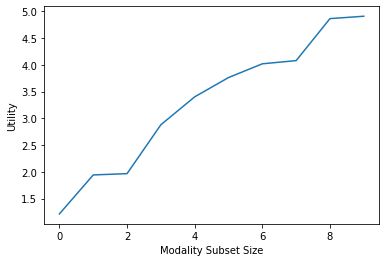

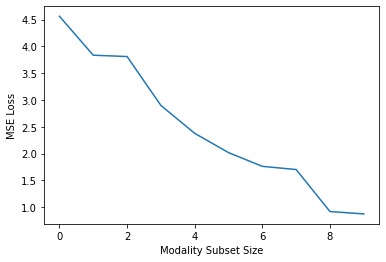

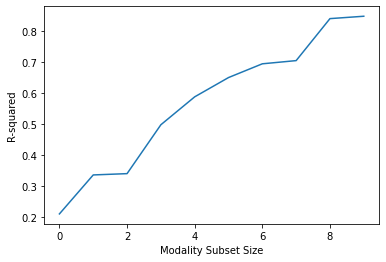

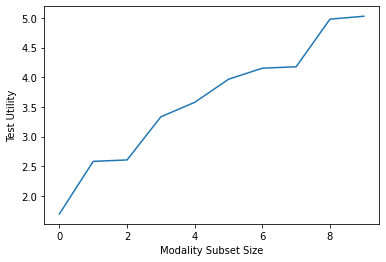

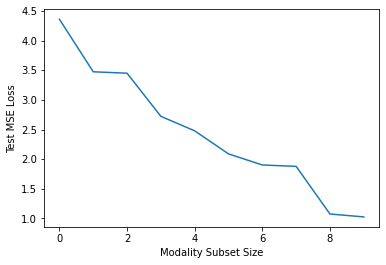

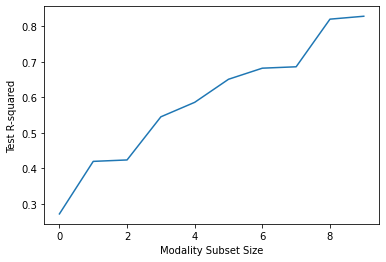

In [44]:
plt.plot(u1)
plt.xlabel("Modality Subset Size")
plt.ylabel("Utility")
plt.show()

plt.plot(m1)
plt.xlabel("Modality Subset Size")
plt.ylabel("MSE Loss")
plt.show()

plt.plot(r1)
plt.xlabel("Modality Subset Size")
plt.ylabel("R-squared")
plt.show()

plt.plot(u2)
plt.xlabel("Modality Subset Size")
plt.ylabel("Test Utility")
plt.show()

plt.plot(m2)
plt.xlabel("Modality Subset Size")
plt.ylabel("Test MSE Loss")
plt.show()

plt.plot(r2)
plt.xlabel("Modality Subset Size")
plt.ylabel("Test R-squared")
plt.show()